# Solve the network dynamics


In [95]:
import numpy as np
import pandas as pd
from collections import Counter
from scipy.stats import bernoulli, loguniform
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from functools import partial
from pathlib import Path
from tqdm.notebook import tqdm
plt.style.use('seaborn-poster')

%matplotlib inline

PATH_TO_DATA = Path('../data')
METHOD = 'RK45'
N_DAYS = 30

Retrieve saved graphs and initial values from `graph_init.ipynb`

In [2]:
G = np.loadtxt(open(PATH_TO_DATA/'graph_complete.csv'), delimiter=",")
G.sum(1)

array([ 0.,  5.,  1., ...,  1., 11.,  1.])

In [3]:
nodes = pd.read_csv(open(PATH_TO_DATA/'empirical_graph_nodes.csv'), delimiter=",").drop(['Unnamed: 0'], 1)
nodes

,step,date,domain,_id,children
0,0.0,2021-01-06,537508,1816056005,[]
1,NaN,2021-01-06,4452,1816132855,[]
2,NaN,2021-01-06,267703,1816195886,[]
3,NaN,2021-01-06,100063,1816238212,[]
4,NaN,2021-01-06,23539,1816336438,[]
...,...,...,...,...,...
2969,NaN,2021-02-05,38907,1843892109,[]
2970,NaN,2021-02-05,368186,1843827906,[]
2971,NaN,2021-02-05,157349,1843729662,[]
2972,NaN,2021-02-05,158115,1843976290,[]


Load the list of domains (posts' sources)

In [4]:
with open(PATH_TO_DATA/'graph_original_domains_each_node.txt') as f:
    domains = f.read().splitlines()
len(domains)

2651

In [ ]:
# # create dictionary, one colour to each domain
# total_d = list(set(domains))
# cols = colors.keys()
# color_dict = {'a': 1}

# for pos, i in enumerate(total_d):
#     color_dict[i] = cols[pos]

Get the initial conditions

In [5]:
eig = np.linalg.eig(G)[0].max()
eig

(136.82923238946915+0j)

In [6]:
i0 = np.loadtxt(open(PATH_TO_DATA/'i0.csv'), delimiter=",")
s0 = 1-i0
total_articles = len(i0)
i0

array([1., 1., 1., ..., 0., 0., 0.])

Define the ODE function to pass to a ODE solver

In [7]:
def fun(
    t, # timestep
    y, # old state
    pars, # ODE fixed parrameters
):
    # Get the old state, numpify it
    y = np.array(y)
    # Separate infected (i) and susceptibles (s)
    i, s = y[:total_articles], y[total_articles:]
    # Get ODE fixed parameters, i.e. lambda and a_ij
    A, lamb = pars
    # Get contacts vectors
    M =  (i * A).sum(axis=1)
    # Get trasmission scusceptibles
    N = lamb * s
    # Get new infected
    Q = N*M
    # Propagate for getting delta infected
    dI = -i + Q
    # Propagate for getting delta susceptible
    dS = -Q
    # Return new state
    return np.hstack((dI,dS))

## Finding $\mu$

In [ ]:
def media_recit(G):
    list_c = []
    for node in G.nodes():
        dates_list = [G.nodes()._nodes[j]['date'] for j in G.successors(node)]
        if dates_list != []:
            delta_t = max(dates_list) - G.nodes()._nodes[node]['date']
            dif = delta_t.total_seconds()/(3600*24)
            if dif > 7:
                print(node)
            list_c.append([G.nodes()._nodes[node]['date'].date(),dif])
        else:
            list_c.append([G.nodes()._nodes[node]['date'].date(),0])
    return list_c

In [ ]:
a = media_recit(G)
b = [i[1] for i in a]
plt.hist(b,bins='auto')
plt.plot()
plt.show()

## Finding $\Delta t$

In [ ]:
t = 1/np.mean(b)
t

In [ ]:
DT = t
TIMESTEPS = int((N_DAYS+1)/DT)

## Finding $\lambda$

In [92]:
lambdas = loguniform.rvs(1e-6, 1e-1, size=100)
lambdas_iterator = tqdm(
    lambdas,
    leave=False,
    unit='lambdas',
)
y = []
N_DAYS = 30
TIMESTEPS = 500
for l in lambdas_iterator:
    f = partial(fun, pars=(G, l))
    sol = solve_ivp(
        fun=f,
        t_span=[0,N_DAYS],
        y0=list(i0)+list(s0),
        method=METHOD,
        t_eval=np.linspace(0,N_DAYS,TIMESTEPS))
    y.append(np.max(np.sum(sol.y[:total_articles, :],0)))

  0%|          | 0/100 [00:00<?, ?lambdas/s]

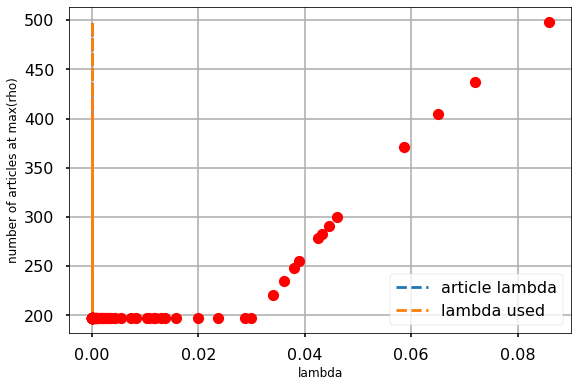

In [94]:
plt.figure(figsize=(9, 6))
plt.plot(len(lambdas)*[8.12645449413e-06], y,'--')
plt.plot(len(lambdas)*[0.0000215], y, '--')
plt.legend(['article lambda','lambda used'], loc=4)
plt.plot(lambdas,y,'ro')
plt.xlabel('lambda',size=12)
plt.ylabel('number of articles at max(rho)', size=12)
plt.grid()
plt.savefig(PATH_TO_DATA/'lambda_validation', dpi=300)

In [ ]:
LAMBDA = 0.04#1.0#0.0000215

In [96]:
f = partial(fun, pars=(G, LAMBDA))
sol = solve_ivp(
    fun=f,
    t_span=[0,N_DAYS],
    y0=list(i0)+list(s0),
    method=METHOD,
    t_eval=np.linspace(0,N_DAYS,TIMESTEPS))
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 146
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.76923077,  1.53846154,  2.30769231,  3.07692308,
        3.84615385,  4.61538462,  5.38461538,  6.15384615,  6.92307692,
        7.69230769,  8.46153846,  9.23076923, 10.        , 10.76923077,
       11.53846154, 12.30769231, 13.07692308, 13.84615385, 14.61538462,
       15.38461538, 16.15384615, 16.92307692, 17.69230769, 18.46153846,
       19.23076923, 20.        , 20.76923077, 21.53846154, 22.30769231,
       23.07692308, 23.84615385, 24.61538462, 25.38461538, 26.15384615,
       26.92307692, 27.69230769, 28.46153846, 29.23076923, 30.        ])
 t_events: None
        y: array([[1.00000000e+00, 4.63370561e-01, 2.14712265e-01, ...,
        1.42266637e-07, 6.32818291e-08, 4.06535851e-08],
       [1.00000000e+00, 4.63370561e-01, 2.14712265e-01, ...,
        1.42266637e-07, 6.32818291e-08

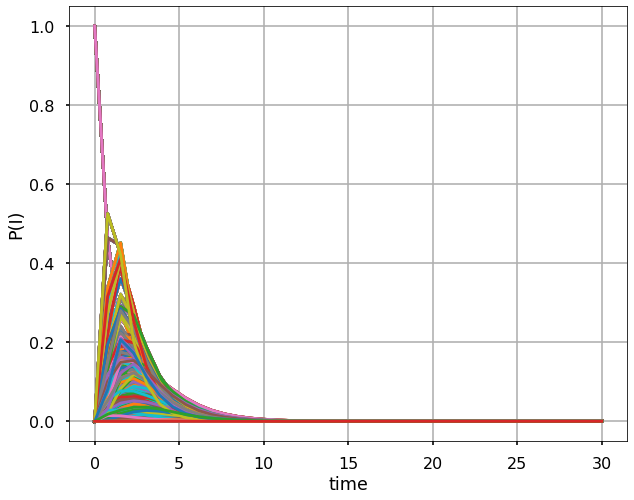

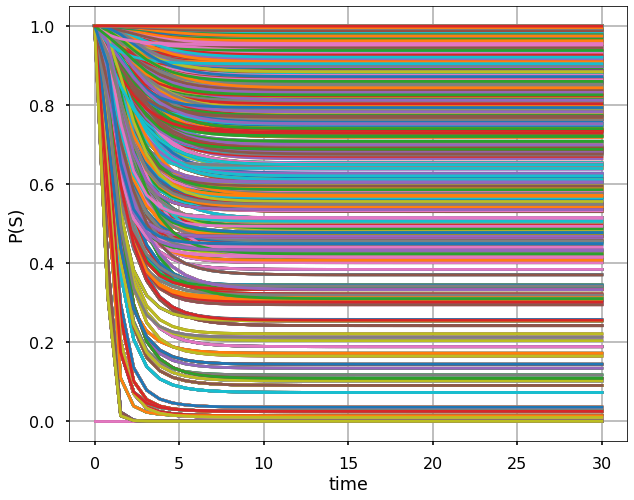

In [99]:
sol_infected, sol_susceptibles = sol.y[:total_articles, :], sol.y[total_articles:, :]
articles_to_plot = np.random.choice(range(total_articles), 10)
articles_to_plot = range(total_articles)
plt.figure(figsize = (10, 8))
[plt.plot(sol.t, sol_infected[i, :]) for i in articles_to_plot]
plt.xlabel('time')
plt.ylabel('P(I)')
#plt.legend(['solution {}'.format(i) for i in articles_to_plot])
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 8))
[plt.plot(sol.t, sol_susceptibles[i, :]) for i in articles_to_plot]
plt.xlabel('time')
plt.ylabel('P(S)')
#plt.legend(['solution {}'.format(i) for i in articles_to_plot])
plt.grid(True)
plt.show()

In [19]:
def create_dI(sol):
    dI, dS = sol.y[:total_articles, :], sol.y[total_articles:, :]
    return dI, dS

In [81]:
np.max(np.sum(sol.y[:total_articles, :],0))

1543.5343786828878

In [69]:
def create_infects(dI,dS):
    dR = 1-dI+dS

    Infects = np.zeros(dI.shape)
    Infects[:,0] = dI[:,0]

    S0 = dS[:,0] - Infects[:,0]
    R0 = np.zeros(dI.shape[0])
    I0 = Infects[:,0]

    for t in range(1,TIMESTEPS):
        a = dI[:,t]*S0
        a[a<0] = 0.0
        a[a>1.0] = 1.0
        b = dR[:,t]*I0
        b[b<0] = 0.0
        b[b>1.0] = 1.0
        I = bernoulli.rvs(a)
        R = bernoulli.rvs(b)

        Infects[:,t] = I0 - R + I
        a = Infects[:,t]

        if len(a[a<0]) > 0:
            b = I0-R
            if len(b[b<0])>0:
                print('ei')


        I0 = Infects[:,t]
        S0 = S0 - I

    return Infects

In [20]:
dI, dS = create_dI(sol)

In [27]:
dI.shape[0]

2974

In [70]:
Infects = create_infects(dI,dS)
Infects

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [73]:
np.savetxt(PATH_TO_DATA/'dI.csv', dI, delimiter=',')
np.savetxt(PATH_TO_DATA/'Infects.csv', Infects, delimiter=',')

## Validate the model

In [ ]:
time_list = [G.nodes()._nodes[j]['date'] for j in G.nodes()] 
dic = Counter(time_list)

In [ ]:
t0 = min(time_list)
d = []
for pos,i in enumerate(time_list):
    dif = time_list[pos].date() - t0.date()
    d.append(dif.days)
    
dic = Counter(d)
p=[]
q=[]
i=0

while len(q) < max(dic)+1: 
    q.append(dic[i])
    i += 1
    
plt.plot(q)

In [ ]:
line_down = plt.plot(b,q,'r')

for i in range(0,9999):
    f = partial(fun, pars=(G, LAMBDA))
    sol = solve_ivp(
        fun=f,
        t_span=[0,N_DAYS],
        y0=list(i0)+list(s0),
        method=METHOD,
        t_eval=np.linspace(0,N_DAYS,TIMESTEPS))
    dI, dS = create_dI(sol)
    Infects = create_infects(dI,dS)
    # Infects = np.loadtxt(open('../charlie_results/Is/Infects%s.csv' %i), delimiter=",")
    a = list(Infects.sum(axis=1))
    b = [pos for pos,i in enumerate(a)]
    line_up = plt.plot(b,a,'b',':o',alpha=0.3)
    
plt.xlabel('time(days)',size=12)
plt.ylabel('number of articles infected',size=12)
plt.legend(['empirical', 'simulated'])
line_down = plt.plot(b,q,'r')


plt.savefig(PATH_TO_DATA/'sim_compar.png', dip=300)